In [2]:
#Importing required libraries

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, concatenate, Activation, BatchNormalization, Add,GlobalMaxPooling2D,Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
import tensorflow as tf
from keras.regularizers import L1
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input

In [3]:
image=ImageDataGenerator(preprocessing_function=preprocess_input,rescale = 1.0/255.0,validation_split=.1)
train=image.flow_from_directory("/content/drive/MyDrive/CNNmod1/Dataset",target_size=(224,224),class_mode='sparse',batch_size=10,subset='training',shuffle=True,seed=123)
testing=image.flow_from_directory("/content/drive/MyDrive/CNNmod1/Dataset",target_size=(224,224),class_mode='sparse',batch_size=1,subset='validation')

Found 1710 images belonging to 2 classes.
Found 190 images belonging to 2 classes.


In [ ]:
train.class_indices

{'def_front': 0, 'ok_front': 1}

In [4]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()

# Set up validation
val_loss = tf.keras.metrics.SparseCategoricalCrossentropy(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')


In [5]:
#Using relu6 activation function 
import numpy as np

def relu6(x):
    return np.clip(x, 0, 6)


In [7]:
#Function for the inverted residual block
def inverted_residual_block(inputs, filters, expansion_factor, stride):
    channel_axis = 1 if K.image_data_format() == 'channels_first' else -1
   
    input_num_filters =  K.int_shape(inputs)[channel_axis]
    inner_num_filters = input_num_filters * expansion_factor

    # Apply pointwise convolution with expansion
    x = layers.Conv2D(inner_num_filters, (1, 1), padding='same',kernel_regularizer=L1(0.005), use_bias=False)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu6')(x)

    # Apply depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size=3, strides=stride, padding='same',kernel_regularizer=L1(0.005), use_bias=False)(x)    
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu6')(x)

    # Apply pointwise convolution to project back to the original number of filters(compressing)
    x = layers.Conv2D(filters, (1, 1), padding='same',kernel_regularizer=L1(0.005), use_bias=False)(x)
    x = layers.BatchNormalization()(x)

    # Apply skip connection for same spatial dimension of tensors(identity skip connction)
    if (stride == 1) and (input_num_filters == filters):
        x = layers.Add()([x, inputs])
        return x
    
    # Apply skip connection using a 1x1 convolution
    # Apply skip connection if the number of filters or resolution changes(convolutional skip connection)
    shortcut = Conv2D(filters, kernel_size=1, strides=stride, padding='same')(inputs)
    shortcut = BatchNormalization()(shortcut)

    return Add()([x, shortcut])

In [8]:
#Base model building
def build_cnn_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Entry block
    x = Conv2D(32, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
   
    x = inverted_residual_block(x, filters=32, expansion_factor=6, stride=2)

    x = inverted_residual_block(x, filters=64, expansion_factor=6, stride=2)
    x = inverted_residual_block(x, filters=64, expansion_factor=6, stride=1)

    x = inverted_residual_block(x, filters=128, expansion_factor=6, stride=2)
    x = inverted_residual_block(x, filters=128, expansion_factor=6, stride=1)
    x = Dropout(0.1)(x)

    x = inverted_residual_block(x, filters=256, expansion_factor=6, stride=2)

    # Exit block
    
    x = Conv2D(256, kernel_size=3,padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu6')(x)
    x = GlobalMaxPooling2D()(x)
    x = Dropout(0.1)(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    return model

In [9]:
model1=build_cnn_model((224,224,3),2)

In [10]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)

In [11]:
optimizer = Adam(learning_rate=0.0001)
model1.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy', val_loss, val_accuracy])


In [ ]:
model1.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_40 (Conv2D)             (None, 112, 112, 16  2368        ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_53 (BatchN  (None, 112, 112, 16  64         ['conv2d_40[0][0]']              
 ormalization)                  )                                                           

In [12]:
model1.fit(train, validation_data=testing, epochs=30, callbacks=[early_stop])


Epoch 1/30
171/171 [==============================] - 764s 4s/step - loss: 140.6452 - accuracy: 0.5971 - val_loss: 134.7073 - val_accuracy: 0.5000 - val_val_loss: 0.6941 - val_val_accuracy: 0.5000
Epoch 2/30
171/171 [==============================] - 82s 478ms/step - loss: 128.3935 - accuracy: 0.8491 - val_loss: 122.5210 - val_accuracy: 0.5000 - val_val_loss: 0.7846 - val_val_accuracy: 0.5000
Epoch 3/30
171/171 [==============================] - 81s 474ms/step - loss: 115.3666 - accuracy: 0.9187 - val_loss: 109.4197 - val_accuracy: 0.5000 - val_val_loss: 0.9555 - val_val_accuracy: 0.5000
Epoch 4/30
171/171 [==============================] - 82s 481ms/step - loss: 101.8529 - accuracy: 0.9614 - val_loss: 95.7163 - val_accuracy: 0.6526 - val_val_loss: 0.7547 - val_val_accuracy: 0.6526
Epoch 5/30
171/171 [==============================] - 83s 483ms/step - loss: 88.4088 - accuracy: 0.9708 - val_loss: 82.4405 - val_accuracy: 0.6474 - val_val_loss: 0.7039 - val_val_accuracy: 0.6474
Epoch 6/30

In [13]:
y_pred=model1.predict(testing)

190/190 [==============================] - 10s 49ms/step


In [14]:
y_true = testing.classes

from sklearn.metrics import confusion_matrix
import numpy as np

y_pred=np.argmax(y_pred,axis=1)
y_pred

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0,
       1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0])

In [15]:
cm = confusion_matrix(y_true,y_pred)
TP = cm[1, 1]
TN = cm[0, 0]
FP = cm[0, 1]
FN = cm[1, 0]

accuracy = (TP + TN) / (TP + TN + FP + FN)
precision = TP / (TP + FP)
recall = TP / (TP + FN)

print("Accuracy: {:.2f}".format(accuracy))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.56
Precision: 0.66
Recall: 0.24


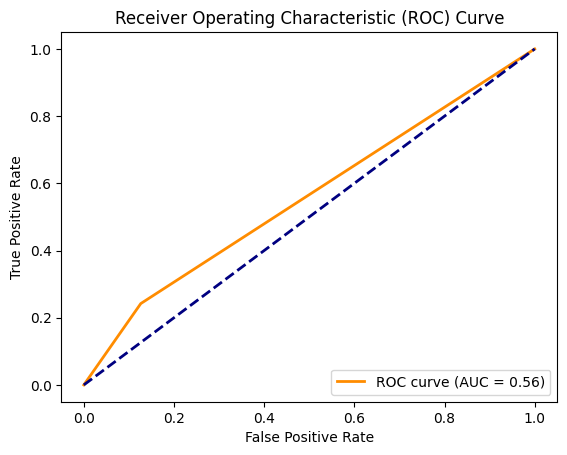

In [16]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# assume y_true and y_score are the true labels and predicted probabilities, respectively
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()